In [36]:
from qiskit_experiments.library import CrossResonanceHamiltonian
import numpy as np
import pandas as pd
from qiskit_experiments.calibration_management.calibrations import Calibrations
from qiskit_experiments.calibration_management.basis_gate_library import FixedFrequencyTransmon
from qiskit_dynamics import Solver
import numpy as np
from qiskit.transpiler import InstructionProperties
import jax
from qiskit import pulse

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

In [37]:
dim = 3

v0 = 4.1e9
anharm0 = -0.24e9
r0 = 0.1e9

v1 = 4.2e9
anharm1 = -0.22e9
r1 = 0.1e9

J = 0.0007464e9

a = np.diag(np.sqrt(np.arange(1, dim)), 1)
adag = np.diag(np.sqrt(np.arange(1, dim)), -1)
N = np.diag(np.arange(dim))

ident = np.eye(dim, dtype=complex)
full_ident = np.eye(dim**2, dtype=complex)

N0 = np.kron(ident, N)
N1 = np.kron(N, ident)

a0 = np.kron(ident, a)
a1 = np.kron(a, ident)

a0dag = np.kron(ident, adag)
a1dag = np.kron(adag, ident)


static_ham0 = 2 * np.pi * v0 * N0 + np.pi * anharm0 * N0 * (N0 - full_ident)
static_ham1 = 2 * np.pi * v1 * N1 + np.pi * anharm1 * N1 * (N1 - full_ident)

static_ham_full = static_ham0 + static_ham1 + 2 * np.pi * J * ((a0 + a0dag) @ (a1 + a1dag))

drive_op0 = 2 * np.pi * r0 * (a0 + a0dag)
drive_op1 = 2 * np.pi * r1 * (a1 + a1dag)

In [38]:
dt = 1/4.5e9

solver = Solver(
    static_hamiltonian=static_ham_full,
    hamiltonian_operators=[drive_op0, drive_op1, drive_op0, drive_op1],
    rotating_frame=static_ham_full,
    hamiltonian_channels=["d0", "d1", "u0", "u1"],
    channel_carrier_freqs={"d0": v0, "d1": v1, "u0": v1, "u1": v0},
    dt=dt,
    array_library="jax",
)

In [39]:
from qiskit_dynamics import DynamicsBackend

# Consistent solver option to use throughout notebook
solver_options = {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8, "hmax": dt}

backend = DynamicsBackend(
    solver=solver,
    subsystem_dims=[dim, dim], # for computing measurement data
    solver_options=solver_options, # to be used every time run is called
)

In [40]:
from qiskit.circuit.library import XGate, SXGate, RZGate, CXGate
from qiskit.circuit import Parameter
from qiskit.providers.backend import QubitProperties
target = backend.target

# qubit properties
target.qubit_properties = [QubitProperties(frequency=v0), QubitProperties(frequency=v1)]

# add instructions
# target.add_instruction(XGate(), properties={(0,): None, (1,): None})
# target.add_instruction(SXGate(), properties={(0,): None, (1,): None})

target.add_instruction(CXGate(), properties={(0, 1): None, (1, 0): None})

# Add RZ instruction as phase shift for drag cal
phi = Parameter("phi")
with pulse.build() as rz0:
    pulse.shift_phase(phi, pulse.DriveChannel(0))
    pulse.shift_phase(phi, pulse.ControlChannel(1))

with pulse.build() as rz1:
    pulse.shift_phase(phi, pulse.DriveChannel(1))
    pulse.shift_phase(phi, pulse.ControlChannel(0))

target.add_instruction(
    RZGate(phi),
    {(0,): InstructionProperties(calibration=rz0), (1,): InstructionProperties(calibration=rz1)}
)

In [41]:
cals = Calibrations(libraries=[FixedFrequencyTransmon(basis_gates=['x', 'sx'])])

pd.DataFrame(**cals.parameters_table(qubit_list=[0, ()]))

,parameter,qubits,schedule,value,group,valid,date_time,exp_id
0,σ,(),sx,40.00,default,True,2024-09-30 14:41:46.692032+0200,None
1,angle,(),x,0.00,default,True,2024-09-30 14:41:46.692032+0200,None
2,amp,(),x,0.50,default,True,2024-09-30 14:41:46.692032+0200,None
3,amp,(),sx,0.25,default,True,2024-09-30 14:41:46.692032+0200,None
4,β,(),x,0.00,default,True,2024-09-30 14:41:46.692032+0200,None
5,duration,(),sx,160.00,default,True,2024-09-30 14:41:46.692032+0200,None
6,σ,(),x,40.00,default,True,2024-09-30 14:41:46.692032+0200,None
7,duration,(),x,160.00,default,True,2024-09-30 14:41:46.692032+0200,None
8,angle,(),sx,0.00,default,True,2024-09-30 14:41:46.692032+0200,None
9,β,(),sx,0.00,default,True,2024-09-30 14:41:46.692032+0200,None


In [42]:
from qiskit_experiments.library.calibration import RoughXSXAmplitudeCal

# rabi experiments for qubit 0
rabi0 = RoughXSXAmplitudeCal([0], cals, backend=backend, amplitudes=np.linspace(-0.2, 0.2, 27))

# rabi experiments for qubit 1
rabi1 = RoughXSXAmplitudeCal([1], cals, backend=backend, amplitudes=np.linspace(-0.2, 0.2, 27))

In [43]:
rabi0_data = rabi0.run().block_for_results()
rabi1_data = rabi1.run().block_for_results()

In [50]:
pd.DataFrame(**cals.parameters_table(qubit_list=[0, ()]))

,parameter,qubits,schedule,value,group,valid,date_time,exp_id
0,σ,(),sx,40.000000,default,True,2024-09-30 14:41:46.692032+0200,None
1,amp,"(0,)",x,0.266047,default,True,2024-09-30 14:41:47.481720+0200,2a93ff02-62a2-40b9-9cfd-8d6642ecb30f
2,angle,(),x,0.000000,default,True,2024-09-30 14:41:46.692032+0200,None
3,amp,"(0,)",sx,0.133023,default,True,2024-09-30 14:41:47.481720+0200,2a93ff02-62a2-40b9-9cfd-8d6642ecb30f
4,amp,(),x,0.500000,default,True,2024-09-30 14:41:46.692032+0200,None
5,amp,(),sx,0.250000,default,True,2024-09-30 14:41:46.692032+0200,None
6,β,(),x,0.000000,default,True,2024-09-30 14:41:46.692032+0200,None
7,duration,(),sx,160.000000,default,True,2024-09-30 14:41:46.692032+0200,None
8,σ,(),x,40.000000,default,True,2024-09-30 14:41:46.692032+0200,None
9,duration,(),x,160.000000,default,True,2024-09-30 14:41:46.692032+0200,None


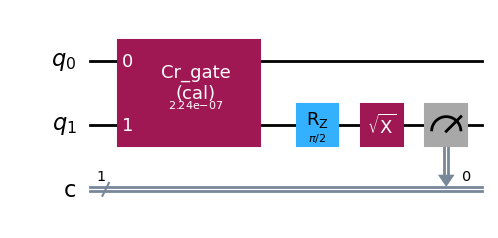

In [47]:
backend.set_options(control_channel_map={(0, 1): 0, (1, 0): 1})
cr_ham_experiment = CrossResonanceHamiltonian(
    physical_qubits=(0, 1),
    durations=np.linspace(1e-7, 3e-6, 17),
    backend=backend
)

backend.target.update_from_instruction_schedule_map(cals.get_inst_map())

In [48]:
%time data_cr = cr_ham_experiment.run().block_for_results()


CPU times: total: 15.5 s
Wall time: 17.5 s


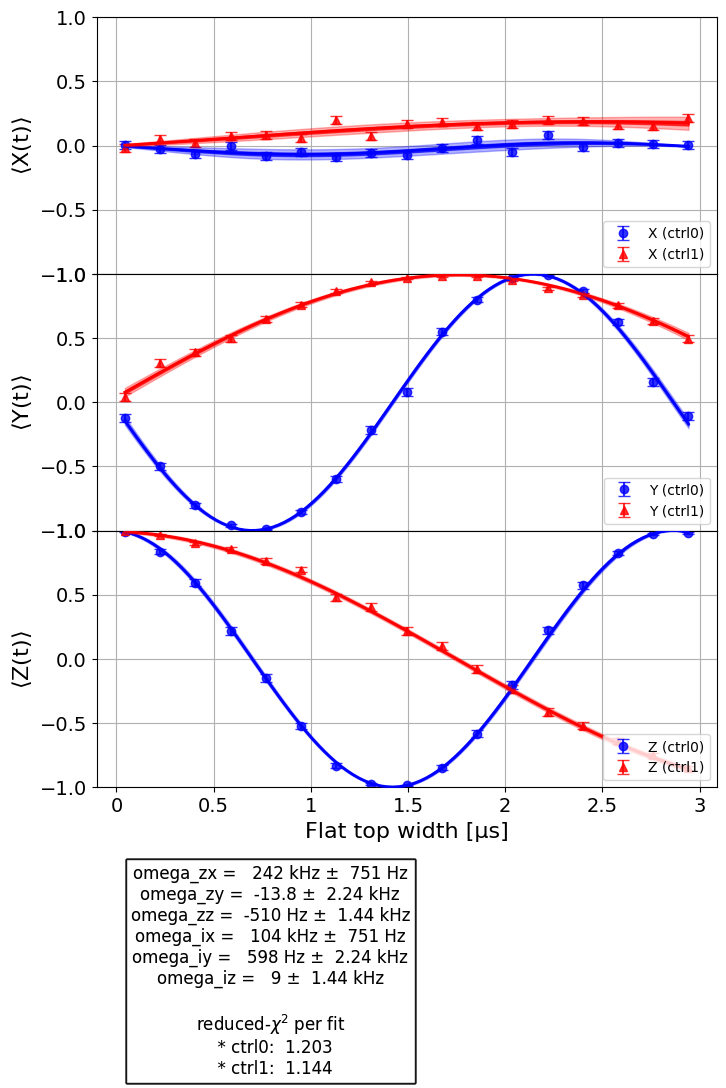

In [49]:
data_cr.figure(0)
